In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay

os.makedirs("models", exist_ok=True)
cols = ['user', 'activity', 'timestamp', 'x-accel', 'y-accel', 'z-accel']
raw_data = pd.read_csv('dataset/wisdm/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None,names=cols, sep=",",on_bad_lines='skip')
raw_data['z-accel'] = raw_data['z-accel'].str.replace(';', '').astype(float)
raw_data.interpolate(method='linear', limit_direction ='both', inplace=True) # eksik veri tamamlandı

#print(raw_data.head())

C:\Users\aylin\AppData\Local\Temp\ipykernel_13004\1466454539.py:22: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  raw_data.interpolate(method='linear', limit_direction ='both', inplace=True) # eksik veri tamamlandı


In [11]:
#Aktivite ve Kodları:
# 0: Downstairs
# 1: Jogging
# 2: Sitting
# 3: Standing
# 4: Upstairs
# 5: Walking
raw_data['actvity_code'] = raw_data['activity'].astype('category').cat.codes
work_data = raw_data[['user','actvity_code','timestamp', 'x-accel', 'y-accel', 'z-accel']]

In [12]:
sample_frequency = 20
seconds=3
window_size = seconds * sample_frequency #20Hz 3 seconds 20*3=60
feature_count = 3 #x,y,z
step = window_size # for non-overlap segments

segments = []
labels = []

data_for_segmentation = work_data[['x-accel', 'y-accel', 'z-accel']].values
labels_for_segmentation = work_data['actvity_code'].values

for user in work_data['user'].unique():
    for act_code in work_data['actvity_code'].unique():
        s_index = work_data.index[(work_data['user'] == user) & (work_data['actvity_code'] == act_code)].tolist()
        for i in range(0, len(s_index) - window_size, step):
            window_start = s_index[i]
            window_end = window_start + window_size
            
            segment = data_for_segmentation[window_start : window_end]
            label = stats.mode(labels_for_segmentation[window_start : window_end], keepdims=True).mode[0]
            
            segments.append(segment)
            labels.append(label)

reshaped_segments = np.asarray(segments, dtype=np.float32)
labels = np.asarray(labels)
#print(reshaped_segments)

In [13]:
feature_list = []

for i in range(reshaped_segments.shape[0]): #bütün segmentler, 18bin tane yklşk
    segment = reshaped_segments[i]
    segment_features = []
    
    for j in range(segment.shape[1]): #3 ekseni dön, xyz
        data = segment[:, j]
        segment_features.append(np.mean(data))
        segment_features.append(np.min(data))
        segment_features.append(np.max(data))
        segment_features.append(np.std(data))
        segment_features.append(np.median(data))
        segment_features.append(stats.median_abs_deviation(data)) #mad
        segment_features.append(np.sqrt(np.mean(data**2))) #rsm
        segment_features.append(np.sum(data**2)) #enerji - jog/walk yüksek enerji, sit/stand düşük enerji
        
        hist, _ = np.histogram(data, bins=10, density=True)
        segment_features.append(stats.entropy(hist))  #entropi

    feature_list.append(segment_features)
    
#print(len(feature_list))
#print(feature_list[0])
#print(feature_list[1])
feature_extraction = pd.DataFrame(feature_list)

feature_names = ['mean', 'min', 'max', 'std', 'median', 'mad', 'rms', 'energy', 'entropy']
axis_name = ['x', 'y', 'z']
column_names = [f'{axis}_{feat}' for axis in axis_name for feat in feature_names ]
feature_extraction.columns = column_names
y_labels = labels.ravel()

#print(feature_extraction.head())

In [14]:
x_train, x_test, y_train, y_test = train_test_split(feature_extraction, y_labels, test_size=0.3, random_state=17,stratify =y_labels)

#StandardScaler (SVM, KNN, MLP)
scaler = StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)

joblib.dump(scaler, 'models/wisdm/standard_scaler.joblib')
#PCA
pca = PCA(n_components=0.95, random_state=17)
x_train_pca=pca.fit_transform(x_train)
x_test_pca=pca.transform(x_test)


In [15]:
activity_labels = list(raw_data['activity'].astype('category').cat.categories)

def model_train(model, x_train, y_train, x_test, y_test, name, pca):
    print(f"Model: {name} {pca}")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
   
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
    print(classification_report(y_test, y_pred, target_names=activity_labels, zero_division=0))
    print("Confusion Matrix:")
    figure, axes = plt.subplots(figsize=(7, 7))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=activity_labels,
        cmap='Greens',  
        xticks_rotation='horizontal', 
        ax=axes 
    )
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    joblib.dump(model, f'models/wisdm/{name}_{pca.replace(" ", "_")}_WISDM.joblib')

WITHOUT PCA

Model: SVM Without PCA
Accuracy: 0.8997

              precision    recall  f1-score   support

  Downstairs       0.78      0.55      0.65       501
     Jogging       0.97      0.99      0.98      1679
     Sitting       1.00      0.95      0.97       295
    Standing       0.94      0.99      0.97       238
    Upstairs       0.78      0.61      0.69       605
     Walking       0.88      0.98      0.93      2086

    accuracy                           0.90      5404
   macro avg       0.89      0.85      0.86      5404
weighted avg       0.89      0.90      0.89      5404

Confusion Matrix:


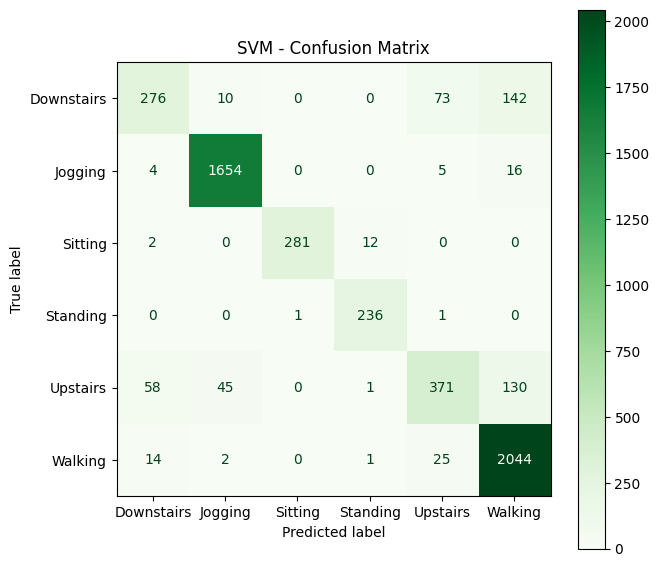

Model: Random Forest Without PCA
Accuracy: 0.9308

              precision    recall  f1-score   support

  Downstairs       0.87      0.68      0.76       501
     Jogging       0.96      0.99      0.98      1679
     Sitting       1.00      0.98      0.99       295
    Standing       0.98      1.00      0.99       238
    Upstairs       0.85      0.74      0.79       605
     Walking       0.92      0.99      0.95      2086

    accuracy                           0.93      5404
   macro avg       0.93      0.89      0.91      5404
weighted avg       0.93      0.93      0.93      5404

Confusion Matrix:


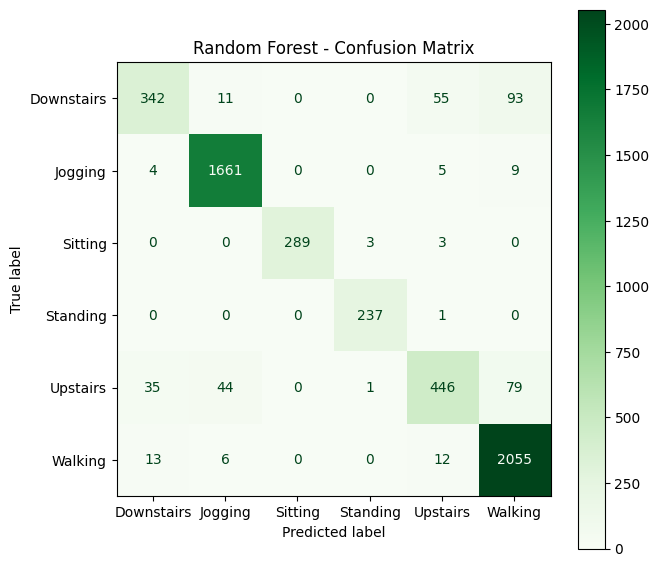

Model: KNN Without PCA
Accuracy: 0.9375

              precision    recall  f1-score   support

  Downstairs       0.83      0.78      0.80       501
     Jogging       0.98      0.99      0.98      1679
     Sitting       0.99      0.97      0.98       295
    Standing       0.97      1.00      0.98       238
    Upstairs       0.88      0.72      0.79       605
     Walking       0.93      0.98      0.96      2086

    accuracy                           0.94      5404
   macro avg       0.93      0.91      0.92      5404
weighted avg       0.94      0.94      0.94      5404

Confusion Matrix:


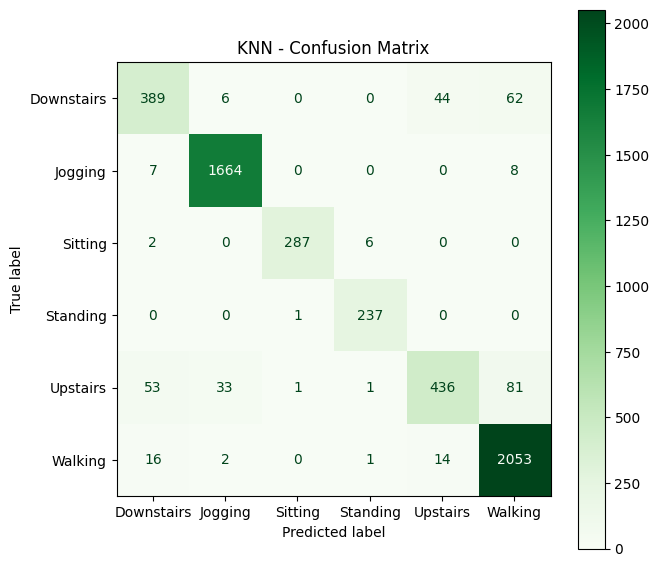

Model: XGBoost Without PCA
Accuracy: 0.9386

              precision    recall  f1-score   support

  Downstairs       0.83      0.74      0.78       501
     Jogging       0.98      0.99      0.98      1679
     Sitting       1.00      0.98      0.99       295
    Standing       0.99      1.00      0.99       238
    Upstairs       0.84      0.78      0.81       605
     Walking       0.95      0.98      0.96      2086

    accuracy                           0.94      5404
   macro avg       0.93      0.91      0.92      5404
weighted avg       0.94      0.94      0.94      5404

Confusion Matrix:


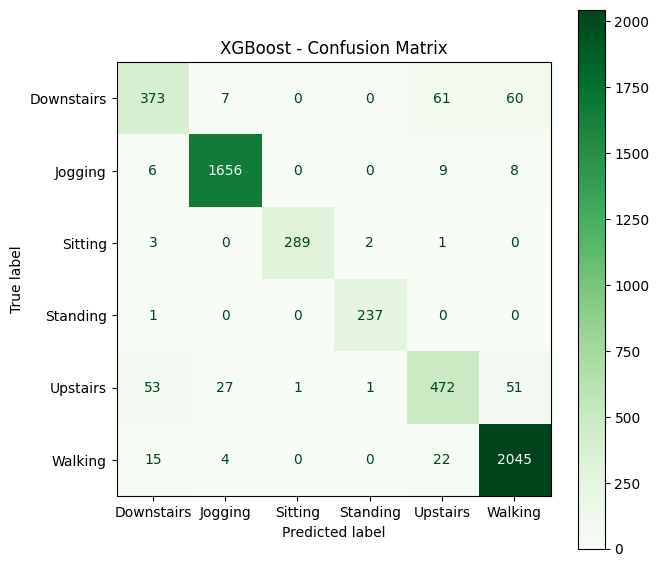

Model: MLP Without PCA
Accuracy: 0.9339

              precision    recall  f1-score   support

  Downstairs       0.81      0.75      0.78       501
     Jogging       0.97      0.99      0.98      1679
     Sitting       1.00      0.97      0.98       295
    Standing       0.97      0.99      0.98       238
    Upstairs       0.84      0.75      0.79       605
     Walking       0.94      0.98      0.96      2086

    accuracy                           0.93      5404
   macro avg       0.92      0.90      0.91      5404
weighted avg       0.93      0.93      0.93      5404

Confusion Matrix:


c:\Users\aylin\Desktop\470projee\Human-Activity-Recognition-with-Smart-Devices\tf-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


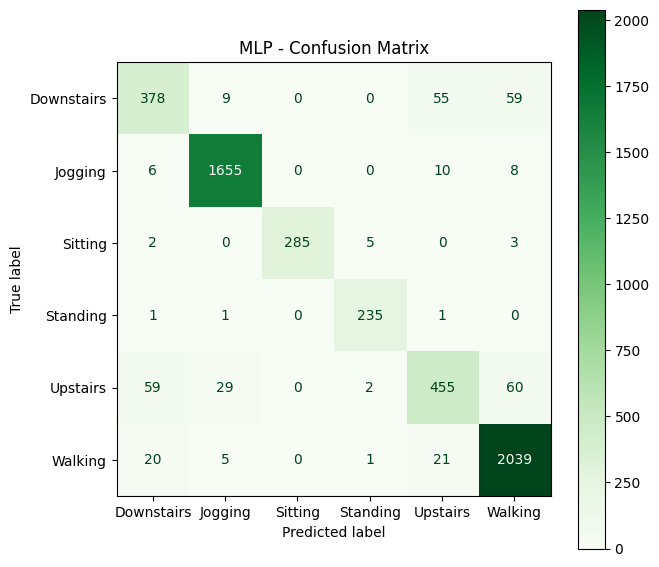

Model: Naive Bayes Without PCA
Accuracy: 0.7370

              precision    recall  f1-score   support

  Downstairs       0.26      0.48      0.34       501
     Jogging       0.88      0.95      0.91      1679
     Sitting       0.99      0.95      0.97       295
    Standing       0.95      0.98      0.96       238
    Upstairs       0.52      0.32      0.40       605
     Walking       0.81      0.70      0.75      2086

    accuracy                           0.74      5404
   macro avg       0.74      0.73      0.72      5404
weighted avg       0.76      0.74      0.74      5404

Confusion Matrix:


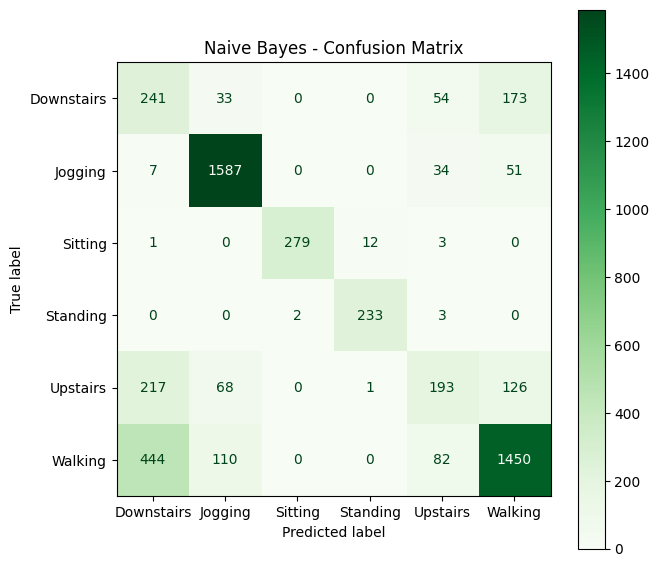

In [16]:
models_without_pca = [
    ("SVM", SVC(random_state=17), x_train_scaled, x_test_scaled),
    ("Random Forest", RandomForestClassifier(random_state=17), x_train, x_test),
    ("KNN", KNeighborsClassifier(), x_train_scaled, x_test_scaled),
    ("XGBoost", XGBClassifier(verbosity=0, use_label_encoder=False, random_state=17), x_train, x_test),
    ("MLP", MLPClassifier(max_iter=300,random_state=17), x_train_scaled, x_test_scaled),
    ("Naive Bayes", GaussianNB(), x_train, x_test)
]

for name, model, xTrain, xTest in models_without_pca:
    model_train(model, xTrain, y_train, xTest, y_test, name, pca='Without PCA')

WITH PCA 


Model: SVM With PCA
Accuracy: 0.8779

              precision    recall  f1-score   support

  Downstairs       0.77      0.40      0.52       501
     Jogging       0.96      0.98      0.97      1679
     Sitting       1.00      0.95      0.97       295
    Standing       0.94      0.99      0.97       238
    Upstairs       0.70      0.55      0.62       605
     Walking       0.84      0.98      0.91      2086

    accuracy                           0.88      5404
   macro avg       0.87      0.81      0.83      5404
weighted avg       0.87      0.88      0.87      5404

Confusion Matrix:


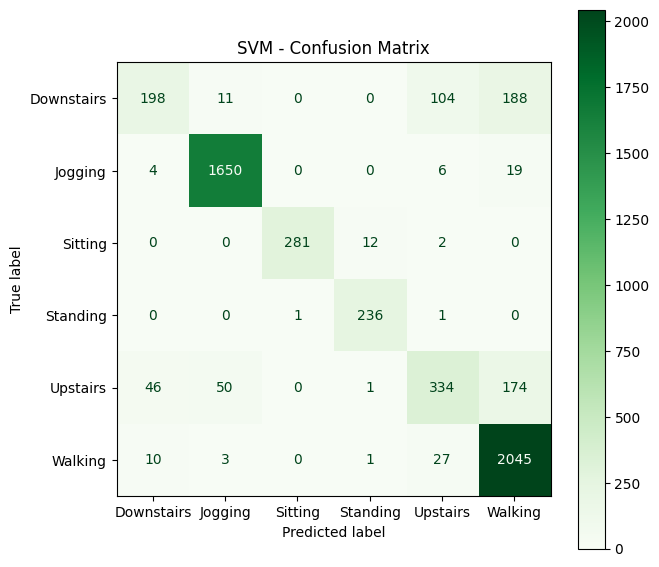

Model: Random Forest With PCA
Accuracy: 0.7894

              precision    recall  f1-score   support

  Downstairs       0.55      0.29      0.38       501
     Jogging       0.90      0.88      0.89      1679
     Sitting       0.98      0.99      0.98       295
    Standing       0.94      0.99      0.97       238
    Upstairs       0.58      0.41      0.48       605
     Walking       0.74      0.90      0.81      2086

    accuracy                           0.79      5404
   macro avg       0.78      0.74      0.75      5404
weighted avg       0.78      0.79      0.77      5404

Confusion Matrix:


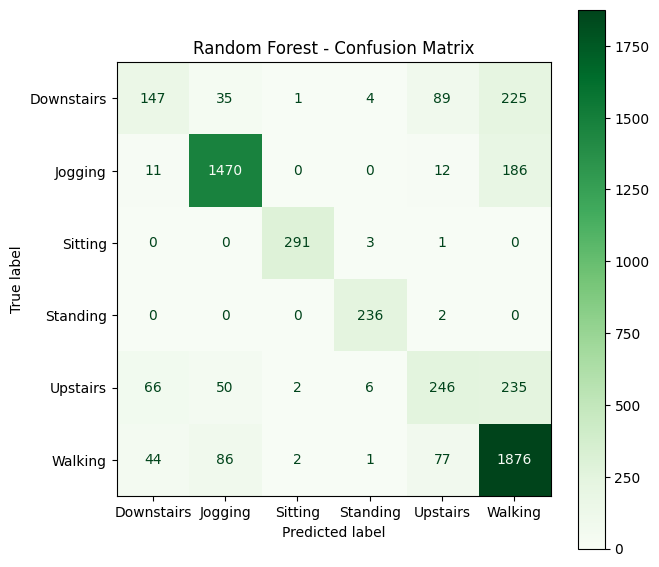

Model: KNN With PCA
Accuracy: 0.9254

              precision    recall  f1-score   support

  Downstairs       0.80      0.70      0.75       501
     Jogging       0.97      0.99      0.98      1679
     Sitting       0.99      0.98      0.98       295
    Standing       0.97      0.99      0.98       238
    Upstairs       0.87      0.69      0.77       605
     Walking       0.92      0.98      0.95      2086

    accuracy                           0.93      5404
   macro avg       0.92      0.89      0.90      5404
weighted avg       0.92      0.93      0.92      5404

Confusion Matrix:


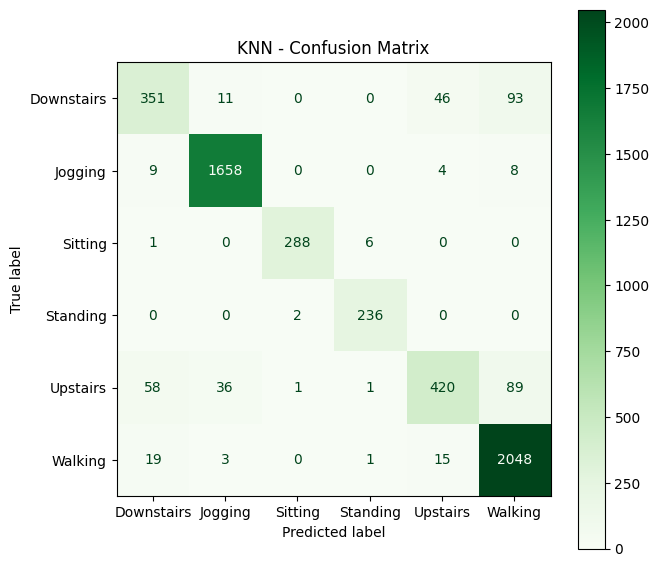

Model: XGBoost With PCA
Accuracy: 0.7822

              precision    recall  f1-score   support

  Downstairs       0.54      0.25      0.34       501
     Jogging       0.90      0.86      0.88      1679
     Sitting       0.98      0.99      0.98       295
    Standing       0.95      0.97      0.96       238
    Upstairs       0.54      0.39      0.45       605
     Walking       0.73      0.91      0.81      2086

    accuracy                           0.78      5404
   macro avg       0.77      0.73      0.74      5404
weighted avg       0.77      0.78      0.76      5404

Confusion Matrix:


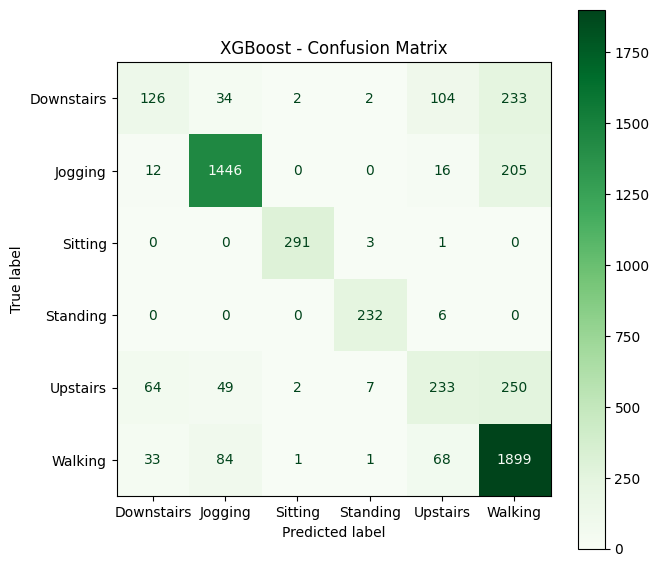

Model: MLP With PCA
Accuracy: 0.9114

              precision    recall  f1-score   support

  Downstairs       0.71      0.70      0.71       501
     Jogging       0.97      0.98      0.98      1679
     Sitting       1.00      0.97      0.98       295
    Standing       0.98      0.99      0.98       238
    Upstairs       0.76      0.69      0.72       605
     Walking       0.93      0.95      0.94      2086

    accuracy                           0.91      5404
   macro avg       0.89      0.88      0.89      5404
weighted avg       0.91      0.91      0.91      5404

Confusion Matrix:


c:\Users\aylin\Desktop\470projee\Human-Activity-Recognition-with-Smart-Devices\tf-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


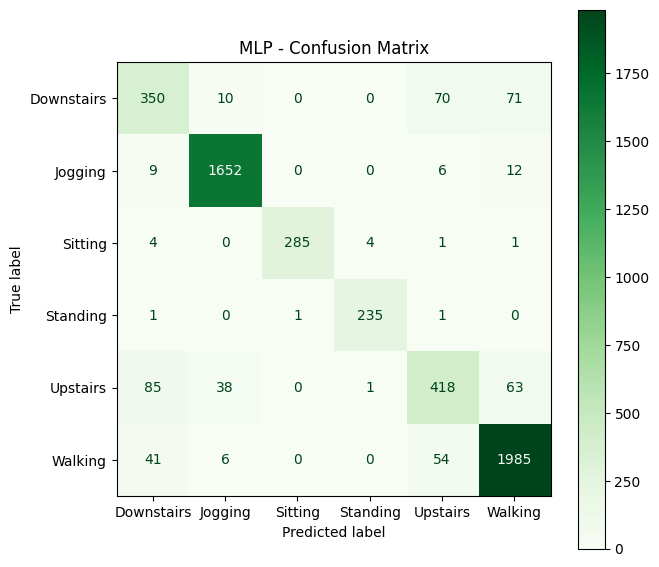

Model: Naive Bayes With PCA
Accuracy: 0.6849

              precision    recall  f1-score   support

  Downstairs       0.00      0.00      0.00       501
     Jogging       0.86      0.77      0.81      1679
     Sitting       0.96      0.95      0.95       295
    Standing       0.74      0.89      0.81       238
    Upstairs       0.34      0.08      0.13       605
     Walking       0.59      0.90      0.71      2086

    accuracy                           0.68      5404
   macro avg       0.58      0.60      0.57      5404
weighted avg       0.62      0.68      0.63      5404

Confusion Matrix:


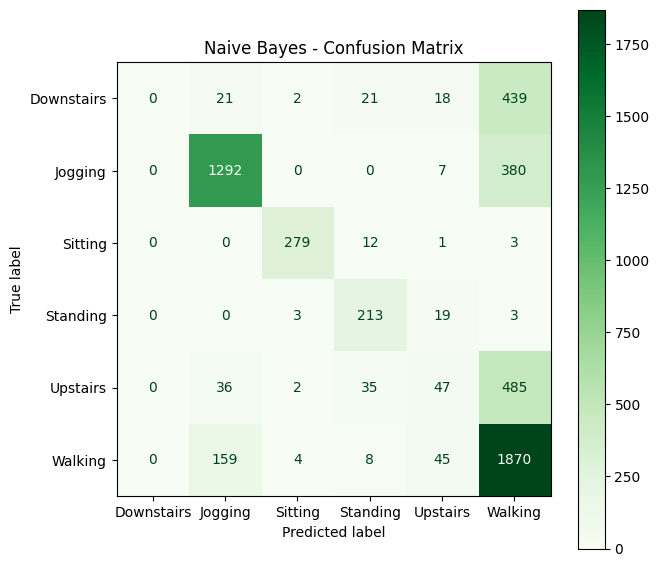

In [17]:
x_train_scaled_pca = pca.fit_transform(x_train_scaled)
x_test_scaled_pca = pca.transform(x_test_scaled)
joblib.dump(pca, 'models/wisdm/pca_transformer.joblib')

models_with_pca = [
    ("SVM", SVC(random_state=17), x_train_scaled_pca, x_test_scaled_pca),
    ("Random Forest", RandomForestClassifier(random_state=17),x_train_pca, x_test_pca ),
    ("KNN", KNeighborsClassifier(), x_train_scaled_pca, x_test_scaled_pca),
    ("XGBoost", XGBClassifier(verbosity=0, use_label_encoder=False,random_state=17),x_train_pca, x_test_pca),
    ("MLP", MLPClassifier(max_iter=300,random_state=17), x_train_scaled_pca, x_test_scaled_pca),
    ("Naive Bayes", GaussianNB(),x_train_pca, x_test_pca)
]

for name, model, xTrain, xTest in models_with_pca:
    model_train(model, xTrain, y_train, xTest, y_test, name, pca='With PCA')

HYPERPARAMETER OPTIMIZATION

---------SVM---------
Accuracy: 0.9006

              precision    recall  f1-score   support

  Downstairs       0.76      0.55      0.64       501
     Jogging       0.97      0.98      0.98      1679
     Sitting       0.99      0.96      0.98       295
    Standing       0.96      0.98      0.97       238
    Upstairs       0.77      0.63      0.69       605
     Walking       0.88      0.98      0.93      2086

    accuracy                           0.90      5404
   macro avg       0.89      0.85      0.86      5404
weighted avg       0.90      0.90      0.89      5404

Confusion Matrix:


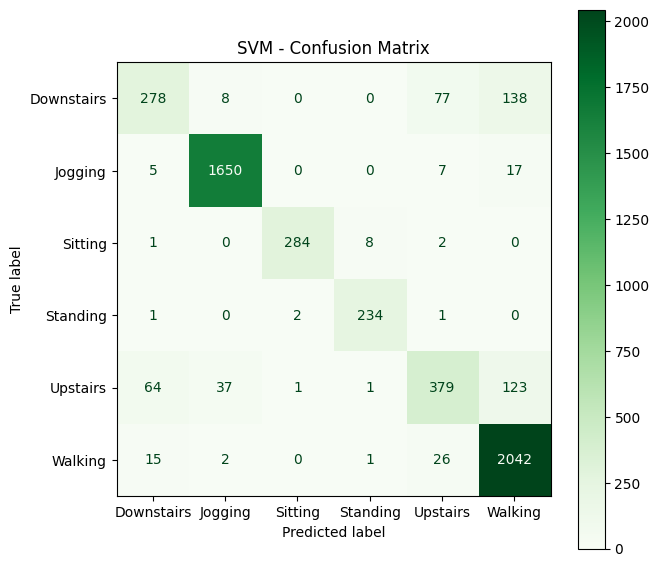


[SVM] Best F1-Score: 0.8642
[SVM] Best Parameters: (10, 'rbf')

---------RF---------
Accuracy: 0.7952

              precision    recall  f1-score   support

  Downstairs       0.60      0.27      0.37       501
     Jogging       0.90      0.87      0.89      1679
     Sitting       0.98      0.99      0.98       295
    Standing       0.95      0.99      0.97       238
    Upstairs       0.61      0.42      0.50       605
     Walking       0.74      0.92      0.82      2086

    accuracy                           0.80      5404
   macro avg       0.80      0.74      0.75      5404
weighted avg       0.78      0.80      0.78      5404

Confusion Matrix:


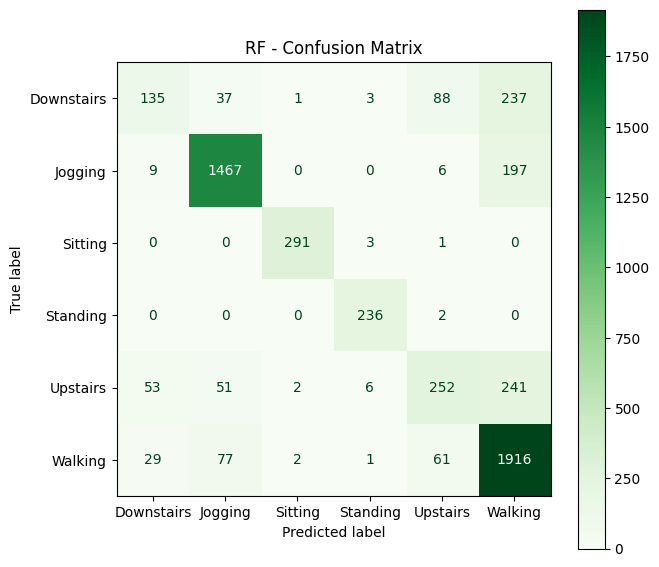


[RF] Best F1-Score: 0.7546
[RF] Best Parameters: (100, 20, 5)

---------KNN---------
Accuracy: 0.9269

              precision    recall  f1-score   support

  Downstairs       0.77      0.73      0.75       501
     Jogging       0.97      0.99      0.98      1679
     Sitting       0.99      0.98      0.98       295
    Standing       0.97      0.99      0.98       238
    Upstairs       0.86      0.69      0.76       605
     Walking       0.92      0.98      0.95      2086

    accuracy                           0.93      5404
   macro avg       0.92      0.89      0.90      5404
weighted avg       0.92      0.93      0.92      5404

Confusion Matrix:


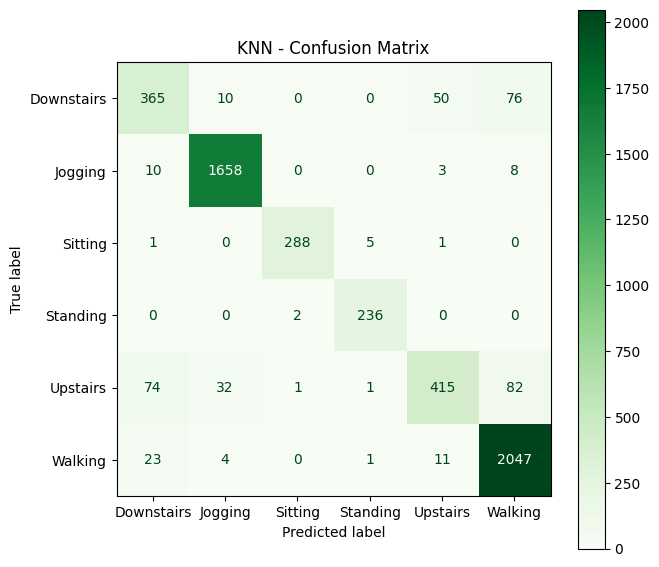


[KNN] Best F1-Score: 0.9019
[KNN] Best Parameters: 3

---------XGBoost---------
Accuracy: 0.7833

              precision    recall  f1-score   support

  Downstairs       0.49      0.28      0.36       501
     Jogging       0.89      0.87      0.88      1679
     Sitting       0.98      0.99      0.98       295
    Standing       0.96      0.98      0.97       238
    Upstairs       0.55      0.43      0.48       605
     Walking       0.75      0.89      0.81      2086

    accuracy                           0.78      5404
   macro avg       0.77      0.74      0.75      5404
weighted avg       0.77      0.78      0.77      5404

Confusion Matrix:


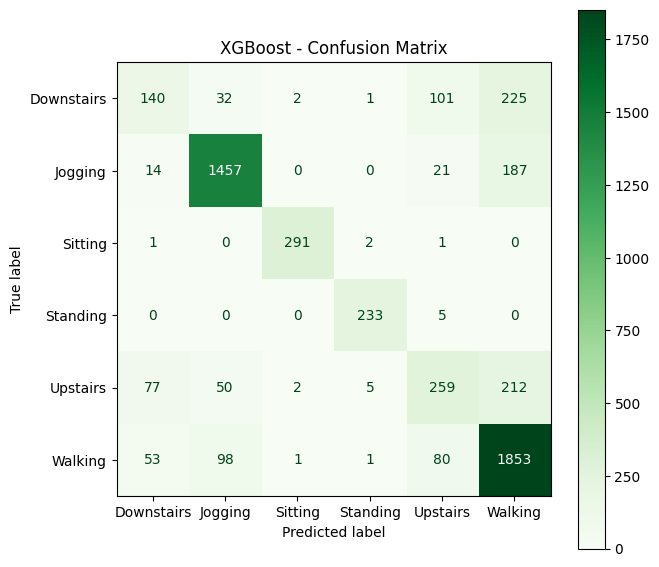


[XGBoost] Best F1-Score: 0.7477
[XGBoost] Best Parameters: (200, 10, 0.1)



c:\Users\aylin\Desktop\470projee\Human-Activity-Recognition-with-Smart-Devices\tf-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\aylin\Desktop\470projee\Human-Activity-Recognition-with-Smart-Devices\tf-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\aylin\Desktop\470projee\Human-Activity-Recognition-with-Smart-Devices\tf-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\aylin\Desktop\470projee\Human-Activity-Recognition-with-Smart-Devices\tf-env\lib\site-packages\sklearn\neural_ne

---------MLP---------
Accuracy: 0.9219

              precision    recall  f1-score   support

  Downstairs       0.76      0.73      0.75       501
     Jogging       0.98      0.98      0.98      1679
     Sitting       0.99      0.97      0.98       295
    Standing       0.96      0.98      0.97       238
    Upstairs       0.79      0.73      0.76       605
     Walking       0.94      0.96      0.95      2086

    accuracy                           0.92      5404
   macro avg       0.90      0.89      0.90      5404
weighted avg       0.92      0.92      0.92      5404

Confusion Matrix:


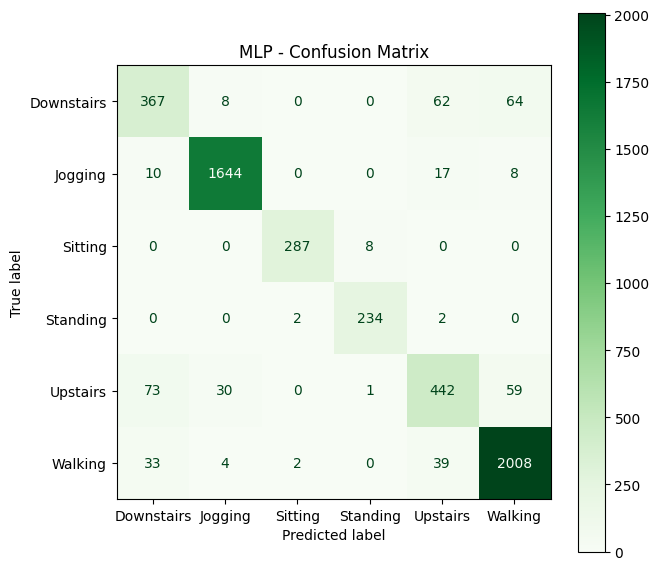


[MLP] Best F1-Score: 0.8973
[MLP] Best Parameters: ((64, 32), 'tanh')



In [18]:
best_param_SVM = None
best_param_RF = None
best_param_KNN = None
best_param_XGBoost = None
best_param_MLP = None

def SVM_optimization(x_train, y_train, x_test, y_test):
    best_f1 = 0
    best_parameters = None
    best_model = None

    for C in [0.1, 1, 10]:
        for kernel in ['linear', 'rbf']:
            model = SVC(C=C, kernel=kernel , random_state=17)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            f1 = f1_score(y_test, y_pred, average='macro')
            if f1 > best_f1:
                best_f1 = f1
                best_parameters = (C, kernel)
                best_model = model

    print("---------SVM---------")
    best_y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, best_y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
            
    print(classification_report(y_test, best_y_pred, target_names=activity_labels, zero_division=0))
            
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(7, 7))
            
    ConfusionMatrixDisplay.from_predictions(
                y_test,
                best_y_pred,
                display_labels=activity_labels,
                cmap='Greens',  
                xticks_rotation='horizontal', 
                ax=ax 
    )
            
    plt.title('SVM - Confusion Matrix')
    plt.show()
    print(f"\n[SVM] Best F1-Score: {best_f1:.4f}")
    print("[SVM] Best Parameters:", best_parameters)
    print()

    joblib.dump(best_model, 'models/wisdm/SVM_HP_optimization_WISDM.joblib')
    return best_parameters

def RF_optimization(x_train, y_train, x_test, y_test):
    best_f1 = 0
    best_parameters = None
    best_model = None

    for n_estimators in [100, 200]:
        for max_depth in [None, 10, 20]:
            for min_samples_split in [2, 5]:
                model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=17)
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)

                f1 = f1_score(y_test, y_pred, average='macro')
                if f1 > best_f1:
                    best_f1 = f1
                    best_parameters = (n_estimators, max_depth, min_samples_split)
                    best_model = model

    print("---------RF---------")
    best_y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, best_y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
            
    
    print(classification_report(y_test, best_y_pred, target_names=activity_labels, zero_division=0))
            
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(7, 7))
            
    ConfusionMatrixDisplay.from_predictions(
                y_test,
                best_y_pred,
                display_labels=activity_labels,
                cmap='Greens',  
                xticks_rotation='horizontal', 
                ax=ax 
    )
            
    plt.title('RF - Confusion Matrix')
    plt.show()
    print(f"\n[RF] Best F1-Score: {best_f1:.4f}")
    print("[RF] Best Parameters:", best_parameters)
    print()
    joblib.dump(best_model, 'models/wisdm/RF_HP_optimization_WISDM.joblib')
    return best_parameters

def KNN_optimization(x_train, y_train, x_test, y_test):
    best_f1 = 0
    best_parameters = None
    best_model = None

    for k in [3, 5, 7, 9]:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        f1 = f1_score(y_test, y_pred, average='macro')
            
        if f1 > best_f1:
            best_f1 = f1
            best_parameters = (k)
            best_model = model

    print("---------KNN---------")
    best_y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, best_y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
            
    
    print(classification_report(y_test, best_y_pred, target_names=activity_labels, zero_division=0))
            
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(7, 7))
            
    ConfusionMatrixDisplay.from_predictions(
                y_test,
                best_y_pred,
                display_labels=activity_labels,
                cmap='Greens',  
                xticks_rotation='horizontal', 
                ax=ax 
    )
            
    plt.title('KNN - Confusion Matrix')
    plt.show()
    print(f"\n[KNN] Best F1-Score: {best_f1:.4f}")
    print("[KNN] Best Parameters:", best_parameters)
    print()
    joblib.dump(best_model, 'models/wisdm/KNN_HP_optimization_WISDM.joblib')
    return best_parameters

def XGBoost_optimization(x_train, y_train, x_test, y_test):
    best_f1 = 0
    best_parameters = None
    best_model = None

    for n_estimators in [100, 200]:
        for max_depth in [3, 6, 10]:
            for learning_rate in [0.1, 0.3]:    
                model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, verbosity=0, use_label_encoder=False, random_state=17)
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)
                
                f1 = f1_score(y_test, y_pred, average='macro')
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_parameters = (n_estimators, max_depth, learning_rate)
                    best_model = model

    
    print("---------XGBoost---------")
    best_y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, best_y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
            
    
    print(classification_report(y_test, best_y_pred, target_names=activity_labels, zero_division=0))
            
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(7, 7))
            
    ConfusionMatrixDisplay.from_predictions(
                y_test,
                best_y_pred,
                display_labels=activity_labels,
                cmap='Greens',  
                xticks_rotation='horizontal', 
                ax=ax 
    )
            
    plt.title('XGBoost - Confusion Matrix')
    plt.show()
    print(f"\n[XGBoost] Best F1-Score: {best_f1:.4f}")
    print("[XGBoost] Best Parameters:", best_parameters)
    print()
    joblib.dump(best_model, 'models/wisdm/XGBOOST_HP_optimization_WISDM.joblib')
    return best_parameters

def MLP_optimization(x_train, y_train, x_test, y_test):
    best_f1 = 0
    best_parameters = None
    best_model = None

    for hl in [(50,), (100,), (64, 32)]:
        for activation in ['relu', 'tanh']:
            model = MLPClassifier(hidden_layer_sizes=hl, activation=activation, max_iter=300, random_state=17)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            f1 = f1_score(y_test, y_pred, average='macro')
            
            if f1 > best_f1:
                best_f1 = f1
                best_parameters = (hl, activation)
                best_model = model

    print("---------MLP---------")
    best_y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, best_y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
            
    
    print(classification_report(y_test, best_y_pred, target_names=activity_labels, zero_division=0))
            
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(7, 7))
            
    ConfusionMatrixDisplay.from_predictions(
                y_test,
                best_y_pred,
                display_labels=activity_labels,
                cmap='Greens',  
                xticks_rotation='horizontal', 
                ax=ax 
    )
            
    plt.title('MLP - Confusion Matrix')
    plt.show()
    print(f"\n[MLP] Best F1-Score: {best_f1:.4f}")
    print("[MLP] Best Parameters:", best_parameters)
    print()
    joblib.dump(best_model, 'models/wisdm/MLP_HP_optimization_WISDM.joblib')
    return best_parameters

best_param_SVM = SVM_optimization(x_train_scaled_pca,y_train,x_test_scaled_pca, y_test)
best_param_RF = RF_optimization(x_train_pca, y_train,x_test_pca, y_test)
best_param_KNN = KNN_optimization(x_train_scaled_pca,y_train,x_test_scaled_pca, y_test)
best_param_XGBoost = XGBoost_optimization(x_train_pca, y_train,x_test_pca, y_test)
best_param_MLP = MLP_optimization(x_train_scaled_pca,y_train,x_test_scaled_pca, y_test)